## Spatial join

Assign three closest childcare centers to census tracts

1. Read and prepare datasets
2. Generate buffers for each census tract centroid
3. Perform a spatial join between buffers and ChildCare Centers (CCC)
4. For each census tract, filter closest three CCC using haversine distance
5. For the three closest CCC, calculate the distance to their corresponding census tract centroid (in km and minutes)

In [4]:
#!pip install geopandas
#!pip install shapely
#!pip install geopy
#!pip install -U googlemaps

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 40.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 10.3 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable


In [79]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from hav_distance import haversine_distance
import googlemaps
from datetime import datetime

In [80]:
# Read and prepare data
ct = gpd.read_file('../data/tl_2023_17_tract/tl_2023_17_tract.shp') # Census Tracts (ct)
ccc_il = pd.read_csv('../data/Child_Care_Centers_clean.csv') # ChilCareCenters (ccc)

print(len(ct))
print(len(ccc_il))

3265
2891


/tmp/ipykernel_4991/1195042109.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct['centroid'] = ct.geometry.centroid


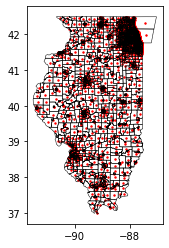

In [81]:
# Calculate centroids and add coordinates as new columns to the original Geo DataFrame
ct['centroid'] = ct.geometry.centroid
ct['centroid_lat'] = ct['centroid'].to_crs(epsg=4326).y
ct['centroid_lon'] = ct['centroid'].to_crs(epsg=4326).x

# Set CRS to avoid spatial issues later
ct.crs = 'EPSG:4326'

# Plot results to check centroids were adequately created
# Plot the original shapefile
ct.boundary.plot(edgecolor='black', linewidth=0.5)

# Plot the centroids on top
ct['centroid'].plot(marker='o', color='red', markersize=2, ax=plt.gca())

plt.show()

In [83]:
# As ccc came from a csv, it needs to be transformed into a Geo DataFrame
ccc_il_gpd = gpd.GeoDataFrame(ccc_il, geometry=gpd.points_from_xy(ccc_il['longitude'], ccc_il['latitude']))

# Set CRS to avoid spatial issues
ccc_il_gpd.crs = 'EPSG:4326'

First analysis: Assign each CCC to the census tract it belongs to

In [84]:
# Perform a spatial join 
ct_ccc = gpd.sjoin(ccc_il_gpd, ct, how='right', op='within')

# Check results
no_ccc = ct_ccc['objectid'].isna().sum() # How many census tracts don't have any CCC
print(len(ct_ccc))
print(no_ccc)


4412
1522


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


There are 1522 census tracts where there aren't any CCC. Thus, this mechanism may not be the best to assign CCC to census tracts.

We will draw a buffer from each census tract centroid and use it to assign CCC to census tracts. The objective is to identify the three closest CCC to each census tract centroid. Thus, in case the buffer captures more than three CCC, haversine_distance will be used to filter the closest three. 

A large buffer (45km) was selected to make sure most census tract buffers' woud capture at least three CCC

In [85]:
# Generate Geo DataFrame with centroids and selected variables (needed for further analysis)
selected_ct_columns = ['GEOID', 'centroid', 'centroid_lon', 'centroid_lat']
ct_buffer = gpd.GeoDataFrame(ct[selected_ct_columns], geometry='centroid').copy()

# Generate a 45km buffer for each centroid
ct_buffer['buffer_45'] = ct_buffer['centroid'].buffer(0.008983*45)

# Set the geometry column explicitly
ct_buffer = ct_buffer.set_geometry('buffer_45')

# Perform spatial join between buffers and CCC points
buffer_ccc = gpd.sjoin(ccc_il_gpd, ct_buffer[['buffer_45', 'GEOID', 'centroid_lat', 'centroid_lon']], how = 'left', op = 'within')

/tmp/ipykernel_4991/3996030080.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct_buffer['buffer_45'] = ct_buffer['centroid'].buffer(0.008983*45)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/tmp/ipykernel_4991/3996030080.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  buffer_ccc = gpd.sjoin(ccc_il_gpd, ct_buffer[['buffer_45', 'GEOID', 'centroid_lat', 'centroid_lon']], how = 'left', op = 'within')


In [86]:
# Check results
print(buffer_ccc['GEOID'].nunique())
print(len(buffer_ccc))

# All census tracts are included
# Large data because of large buffer size

3265
2471246


In [87]:
# Calculate haversine distance for each pair of census tract centroid - CCC
# Filter the three closest for each census tract
buffer_ccc['hdistance'] = buffer_ccc.apply(lambda row: 
                                           haversine_distance(row['latitude'], 
                                                              row['longitude'],
                                                              row['centroid_lat'], 
                                                              row['centroid_lon'],), 
                                                              axis=1)

# Keep only three closest ccc for each census tract
buffer_ccc = buffer_ccc.sort_values(by = 'hdistance')
ct_three_ccc = buffer_ccc.groupby('GEOID').head(3)

In [88]:
# Check results
ccc_count = ct_three_ccc.groupby('GEOID').size().reset_index(name = 'ccc_count')
summary_table = ccc_count['ccc_count'].value_counts().reset_index()
summary_table.columns = ['Number of Points Joined', 'Number of Polygons']
print(summary_table)

   Number of Points Joined  Number of Polygons
0                        3                3262
1                        2                   2
2                        1                   1


### Google distance matrix API

Use Google Directions API to get the distance in km and time (minutes) from each census tract centroid to each of its assigned chilcare centers

In [39]:
GoogleAPI_fn = "Google_distance_API_key.txt"

with open(GoogleAPI_fn, "r") as file:
    api_key = file.readline().strip()

In [110]:
# Create empty coluns to be filled
ct_three_ccc['distance_km'] = 0.0
ct_three_ccc['distance_min'] = 0.0

gmaps = googlemaps.Client(key = api_key)
arrival_time = datetime(2024, 4, 11, 9, 0)

# Set additional counter as an additional stop condition
counter = 0

for i, row in ct_three_ccc.iterrows():
    # Specify origin and destination coordinates
    origin = (row['centroid_lat'], row['centroid_lon'])  # Census tract centroid
    destination = (row['latitude'], row['longitude'])  # CCC coordinates
    
    # Make distance matrix request
    result = gmaps.distance_matrix(origin, destination, mode = 'driving', arrival_time = arrival_time)

    if result['rows'][0]['elements'][0]['status'] == 'OK':
        # Extract the distance value in meters
        distance_in_meters = result['rows'][0]['elements'][0]['distance']['value']
        # Extract the distance value in time
        duration_in_seconds = result['rows'][0]['elements'][0]['duration']['value']

        # Convert distance to kilometers
        ct_three_ccc.loc[i, 'distance_km'] = distance_in_meters / 1000
        # Convert duration to minutes
        ct_three_ccc.loc[i, 'distance_min'] = duration_in_seconds / 60
    else:
        ct_three_ccc.loc[i, 'distance_km'] = 'NaN'
        ct_three_ccc.loc[i, 'distance_min'] = 'NaN'

    # Update counter
    counter += 1

    if counter == len(ct_three_ccc):
        break

/home/rjrivarola/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_4991/4047254788.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ct_three_ccc.loc[i, 'distance_km'] = 'NaN'
/tmp/ipykernel_4991/4047254788.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ct_three_ccc.loc[i, 'dis

In [114]:
# Check results
last_rows = ct_three_ccc['distance_km'].tail(10)
print(last_rows)

2198    44.899
2229    45.991
894     49.929
2085    48.832
2676    42.336
164     42.573
1855    58.362
2198    44.899
123     41.958
912     47.186
Name: distance_km, dtype: object


In [26]:
# Save data as csv
ct_three_ccc.to_csv('../data/census_ccc_joined.csv', index = True)